# LM Denoising Methods for VSD signals of propagating waves in awake monkey visual cortex

The purpose of this notebook is to try to denoise raw VSD signals using the methods developed by Reynaud et al. in https://doi.org/10.1016/j.neuroimage.2010.08.041

This procedure is based on Linear Models (LM) decomposition of the signal. It requires a prior knowledge of the different sources of noise and the shape of the response to denoise. It is a challenge since the methods were already designed to denoise evoked response, whereas here we want also to denoise spontaneous response.

AJOUTER LE PLAN 

### Initialisation

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.colors as colors
import numpy as np
import scipy.ndimage as img
import scipy.signal as signal
import scipy.stats as stat

## 0 : Data loading

Data available are videos of spontaneous and evoked activity int he visual cortex, recorded with ultra fast camera (Fs=110Hz). Raw signals are provided and preprocessed ones (Bks method: zero-frame division, blank substraction and z-score of raw data).

In [2]:
raw_blank_path = r'C:\Users\mmill\Desktop\Data VSD\Awakeness\raw_blank_z210908.npy'
raw_evoked_path = r'C:\Users\mmill\Desktop\Data VSD\Awakeness\raw_pos4_z210908.npy'

bks_blank_path = r'C:\Users\mmill\Desktop\Data VSD\Awakeness\blank_ziggy_210908.npy'
bks_evoked_path = r'C:\Users\mmill\Desktop\Data VSD\Awakeness\gaussian_pos4_ziggy_210908.npy'

awak_pattern_path = r'C:\Users\mmill\Desktop\Data VSD\Awakeness\Awake.bmp'

Raw_blank = np.load(raw_blank_path)
Raw_evoked = np.load(raw_evoked_path)

Bks_blank = np.load(bks_blank_path)
Bks_evoked = np.load(bks_evoked_path)

Vasc_pattern = plt.imread(awak_pattern_path)

## 1 : Visualisation of travelling waves on Bks-processed trials

In [3]:
Data = np.copy(Bks_evoked)

N_trials, Nt, Nx, Ny = Data.shape
N_data = Nt*Nx*Ny

n_trial = 8

Sample = np.copy(Data[n_trial])

#### Temporal filtering (Butterworth filter : lowpass under 20Hz)

In [4]:
butt_filt = signal.butter(N=4, Wn=[20], btype='lowpass', fs=110, output='sos')
Sample=signal.sosfiltfilt(butt_filt, Sample, axis=0)

#### Spatial smoothing (Gaussian filter)

In [5]:
mean = np.nanmean(Sample)
nan_mask = np.isnan(Sample)
Sample[nan_mask]=mean
Smooth  = np.zeros_like(Sample)
for i in range(Nt):
    Smooth[i]=img.gaussian_filter(Sample[i], sigma=5, mode='constant', cval=mean)
Sample=Smooth
Sample[nan_mask]=np.nan

#### Z-score of the data

In [6]:
mean = np.nanmean(Sample)
std = np.nanstd(Sample)
Sample=(Sample-mean)/std

#### Visualisation of waves

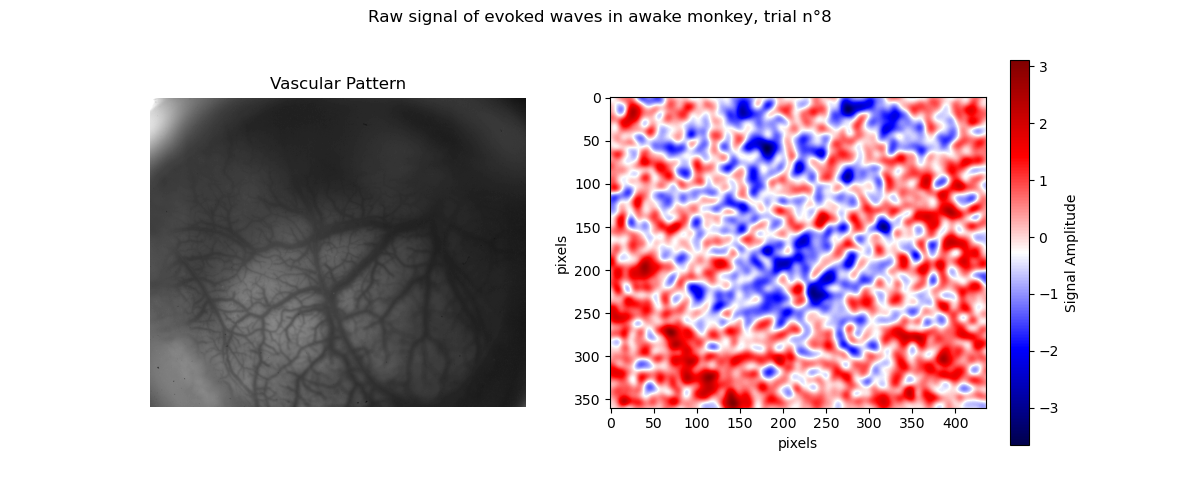

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5), width_ratios=[0.80,1])
fig.suptitle('Raw signal of evoked waves in awake monkey, trial n°'+str(n_trial))

vasculature = ax1.imshow(Vasc_pattern, cmap='gray', aspect='equal')

vsd_signal = ax2.imshow(Sample[0], cmap='seismic', aspect='equal')

cbar = fig.colorbar(vsd_signal, ax=ax2, label='Signal Amplitude')

ax1.set_title('Vascular Pattern')
ax1.axis('off')

ax2.set_xlabel('pixels')
ax2.set_ylabel('pixels')

def update(frame):
    vsd_signal.set_array(Sample[frame])
    ax2.set_title('frame n°'+str(frame))
    return [vsd_signal]

ani = anim.FuncAnimation(fig,func=update,frames=range(Nt),interval=150,repeat=False)
plt.show()


We can observe a noisy traveling wave from frames 23 to 40. Let's put a mask to remove the border to see more clearly the wave. 

#### Masking the border

As the recording aperture is circular, we can use a circular mask, defining the border (out of the circle) and the center (in the circle)

In [8]:
def circular_mask(shape, center, radius):
    Y, X = np.ogrid[:shape[0], :shape[1]]
    return ((X - center[0]) ** 2 + (Y - center[1]) ** 2) <= radius ** 2

In [10]:
image_mask = circular_mask(Sample.shape[1:], center=(220,190), radius=185)

N_center = np.sum(image_mask)
N_border = np.sum(~image_mask)

film_mask = np.array([image_mask for _ in range(Nt)])
                      
masked_sample = np.copy(Sample)
masked_sample[~film_mask]=np.nan

center_series = np.transpose(Sample[:,image_mask])

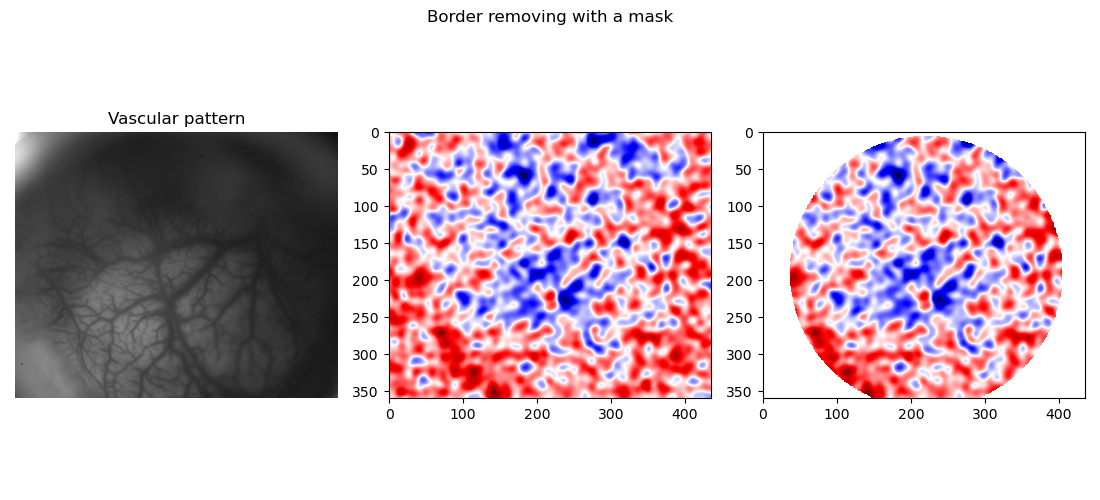

In [12]:
fig, axs = plt.subplots(1,3, tight_layout=True, figsize=(11,5))
fig.suptitle('Border removing with a mask')

axs[0].set_title("Vascular pattern")
axs[0].imshow(Vasc_pattern, cmap='gray', aspect='equal')
axs[0].axis('off')

unmasked = axs[1].imshow(Sample[0], cmap='seismic', aspect='equal')

masked = axs[2].imshow(masked_sample[0], cmap='seismic', aspect='equal')


def update(frame):
    unmasked.set_array(Sample[frame])
    masked.set_array(masked_sample[frame])
    axs[1].set_title('frame n°'+str(frame))
    axs[2].set_title('frame n°'+str(frame))
    return [unmasked, masked]

ani = anim.FuncAnimation(fig,func=update,frames=range(Nt),interval=150,repeat=False)
plt.show()

#### Time series of the Bks-processed signals

Plot time series of randomly-picked pixels within the center

##### Random picking

In [31]:
n_picks = 500

Picked_indices = np.sort(np.random.choice(N_center, n_picks))

Series = center_series[Picked_indices, :]

##### Temporal and total (spatial and temporal) averages of the time series

In [32]:
µ_tot, std_tot = np.nanmean(Series),np.nanstd(Series)
µ, std =np.nanmean(Series, axis=0), np.nanstd(Series, axis=0)

##### Finding the pixels implied in the wave

In [53]:
Wave_indices = np.max(Series, axis=1)>µ_tot+3*std_tot

##### Time series plots

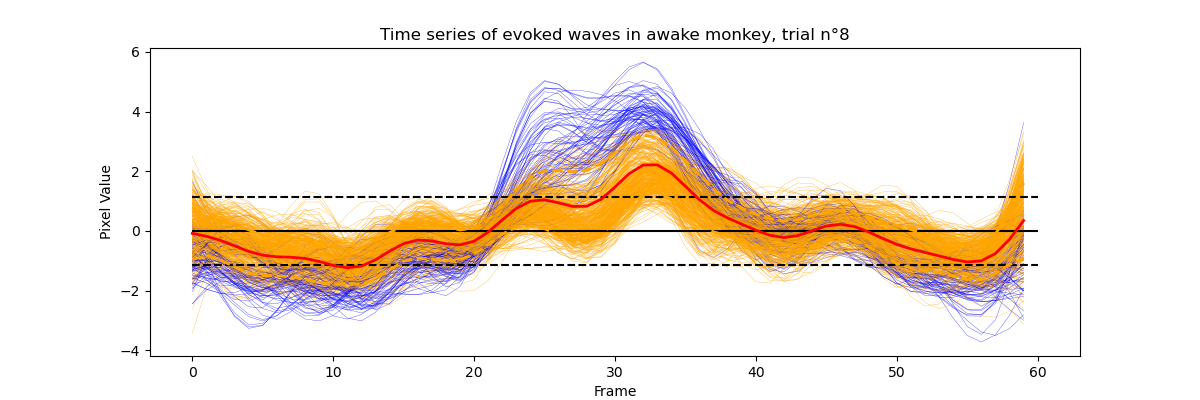

In [54]:
plt.figure(figsize=(12,4))
plt.title('Time series of evoked waves in awake monkey, trial n°'+str(n_trial))

plt.xlabel('Frame')
plt.ylabel('Pixel Value')

for i in range(n_picks):
    if Wave_indices[i]:
        plt.plot(Series[i,:], linewidth=.2, color='blue')
    else:
        plt.plot(Series[i,:], linewidth=.2, color='orange')

plt.hlines(µ_tot, 0, Nt, 'k', linestyles='solid')
plt.hlines(µ_tot+std_tot, 0, Nt, 'k', linestyles='dashed')
plt.hlines(µ_tot-std_tot, 0, Nt, 'k', linestyles='dashed')

plt.plot(µ, 'red', linewidth=2)
plt.plot(µ+std, 'orange', linewidth=2, linestyle='dashed')
plt.plot(µ-std, 'orange', linewidth=2, linestyle='dashed')

plt.show()

#### Power spectra of the time series

In [48]:
fs=110 #Hz
freqs = np.fft.fftfreq(Nt, d=1/fs)
f = freqs[1:Nt//2-1]

ft = np.fft.fft(Series, axis=1)

ps = np.abs(ft)**2

mean_ps = np.mean(ps, axis=0)
ps_mean = np.abs(np.fft.fft(µ))**2

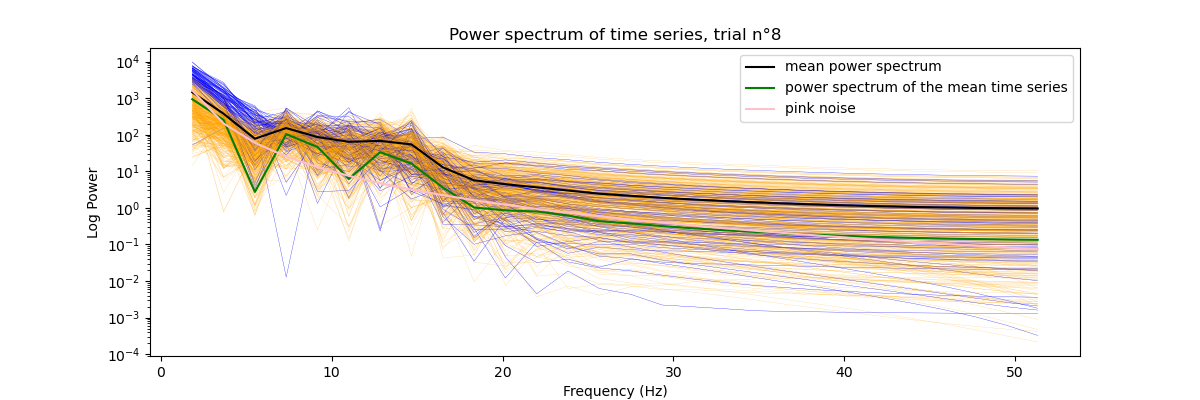

In [74]:
plt.figure(figsize=(12,4))
plt.title('Power spectrum of time series, trial n°'+str(n_trial))

plt.xlabel('Frequency (Hz)')
plt.ylabel('Log Power')
plt.yscale('log')


for i in range(n_picks):
    if Wave_indices[i]:
        plt.plot(f, ps[i,1:Nt//2-1], linewidth=.2, color='blue')
    else:
        plt.plot(f, ps[i,1:Nt//2-1], linewidth=.1, color='orange')
        
plt.plot(f, mean_ps[1:Nt//2-1],color='black', label='mean power spectrum')
plt.plot(f, ps_mean[1:Nt//2-1],color='green', label='power spectrum of the mean time series)

plt.legend()
plt.show()